In [1]:
from art.estimators.classification import KerasClassifier #No soporta TF 2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image

# Disabling eager execution from TF 2
tf.compat.v1.disable_eager_execution()

In [2]:
#Cargamos el modelo

vulnerable_model = tf.keras.models.load_model("modelo_victima_lab6")

In [3]:
# load images as numpy arrays from directory 'malimg_paper_dataset_imgs'
images = []
labels = []
main_directory = './malimg_paper_dataset_imgs'
for subfolder in os.listdir(main_directory):
    subfolder_path = os.path.join(main_directory, subfolder)
    if os.path.isdir(subfolder_path):
        # Iterate over files in the subfolder
        for file_name in os.listdir(subfolder_path):
            # Check if the file has the extension .png
            if file_name.endswith('.png'):
                file_path = os.path.join(subfolder_path, file_name)
                # Load the image using PIL
                image = Image.open(file_path)
                image = image.resize((256,256))
                image = image.convert('L')
                # Convert the image to a NumPy array and add it to the list
                image = np.array(image)
                #if (image_np.shape == (410, 512)):
                images.append([image.tolist()])
                labels.append(subfolder)

In [4]:
# encode categorical labels to integers
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

images = np.array(images)
labels = np.array(labels)

In [5]:
#Dividir el dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [6]:
clasificador = KerasClassifier(
    model=vulnerable_model,
    clip_values=(0, 1))

In [7]:
from art.attacks.inference.model_inversion import MIFace

# Defining a model inversion attack
attack = MIFace(
    classifier=clasificador,
    max_iter=5000, #Este parametro depende del hardware, es el numero de repeticiones para el gradiente descendente
    batch_size=256)

In [8]:
# Defining the target labels for model inversion
y = np.arange(start=0, stop=10)

# Inspecting the target labels
print(y)

[0 1 2 3 4 5 6 7 8 9]


In [9]:
X_test = X_test.reshape(X_test.shape[0], 256, 256, 1)

In [10]:
# Defining an initialization array for model inversion
#La calidad del output depende tambien de este vector de inicializaion
x_init_average = np.zeros(shape=(10, 256, 256, 1)) + np.mean(a=X_test, axis=0)

In [11]:
# Running model inversion
x_infer_from_average = attack.infer(
    x=x_init_average, 
    y=y
    )

Model inversion:   0%|          | 0/1 [00:00<?, ?it/s]

c:\Users\julio\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\engine\training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


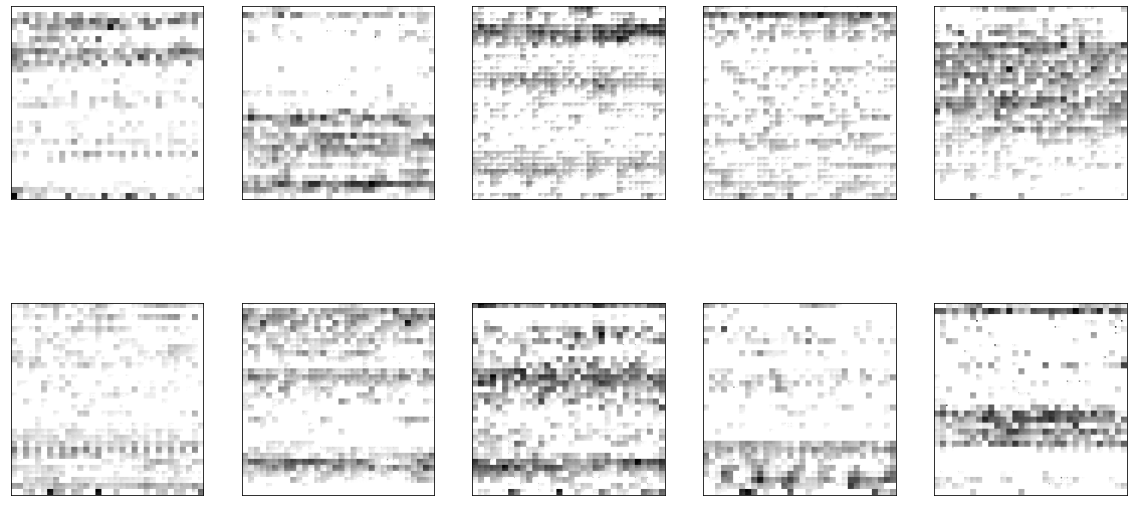

In [12]:
nrows, ncols = 2, 5
# Creating a figure and axes for our plot
fig, axes = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(20, 10)
    )

# Declaring a counting variable
counter = 0

# Iterating over the axes and plotting the inferred images in them
for i in range(nrows):
    for j in range(ncols):        
        axes[i, j].set_xticks(ticks=[])
        axes[i, j].set_yticks(ticks=[])
        axes[i, j].imshow(X=x_infer_from_average[counter], cmap='gray')

        # Incrementing the counter
        counter += 1

# Showing the plotted axes
plt.show()